In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle as p
import networkx as nx
import matplotlib.pyplot as plt
from ActorNetwork import ActorNetwork
import time
import numpy as np
import time, sys, pickle
from collections import defaultdict, deque

min_year=2020
max_year = 2026
basics = pd.read_csv(
    "data/title.basics.tsv",
    sep="\t",
    dtype=str,
    na_values="\\N",
    usecols=["tconst", "titleType", "primaryTitle", "originalTitle", "startYear"]
)

basics = basics[basics["titleType"].isin(["movie", "tvMovie"])].copy()
basics["startYear"] = pd.to_numeric(basics["startYear"], errors="coerce")

basics = basics[
    (basics["startYear"] >= min_year) &
    (basics["startYear"] <= max_year)
].copy()

basics["primary_norm"] = basics["primaryTitle"]
basics["original_norm"] = basics["originalTitle"]

print("IMDb basics rows after filter:", len(basics))


IMDb basics rows after filter: 134268


In [2]:
# -----------------------------
# Load IMDb AKAS (filtered)
# -----------------------------
akas = pd.read_csv(
    "data/title.akas.tsv",
    sep="\t",
    dtype=str,
    na_values="\\N",
    usecols=["titleId", "title"]
)

akas = akas[akas["titleId"].isin(set(basics["tconst"]))].copy()
akas["aka_norm"] = akas["title"]

print("IMDb akas rows after filter:", len(akas))

# -----------------------------
# Load CREW + NAMES (unchanged)
# -----------------------------
crew = pd.read_csv("data/title.crew.tsv", sep="\t", dtype=str, na_values="\\N")
names = pd.read_csv("data/name.basics.tsv", sep="\t", dtype=str, na_values="\\N")

names["name_norm"] = names["primaryName"]
name_map = dict(zip(names["nconst"], names["name_norm"]))

# Build tconst → directors map
director_map = {}
crew["directors"] = crew["directors"].fillna("")
for tconst, dstr in zip(crew["tconst"], crew["directors"]):
    director_map[tconst] = [name_map[d] for d in dstr.split(",") if d in name_map]

# -----------------------------
# FAST Title Index Construction
# -----------------------------
title_index = {}

def add(k, v):
    if k:
        title_index.setdefault(k, set()).add(v)

# Primary + original titles
for t, tc in zip(basics["primary_norm"], basics["tconst"]):
    add(t, tc)

for t, tc in zip(basics["original_norm"], basics["tconst"]):
    add(t, tc)

# Alternate titles
for t, tc in zip(akas["aka_norm"], akas["titleId"]):
    add(t, tc)

print("Title index size:", len(title_index))

IMDb akas rows after filter: 674704
Title index size: 284827


In [ ]:
crew

In [ ]:
names

In [3]:
names["knownForTitles"].apply(lambda x: repr(x)).value_counts().head(10)


knownForTitles
nan             1733359
'tt0123338'        8235
'tt22014400'       7492
'tt4202558'        7290
'tt6168110'        6347
'tt0486535'        5115
'tt0441074'        4875
'tt0072584'        4760
'tt11874658'       4687
'tt0159881'        4377
Name: count, dtype: int64

In [4]:
#names = names[names["knownForTitles"].isna()]
names = names[
   ~names["knownForTitles"].isna() &
    ~names["knownForTitles"].astype(str).str.strip().eq("")
]
names

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,name_norm
0,nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer","tt0072308,tt0050419,tt0027125,tt0025164",Fred Astaire
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack,archive_footage","tt0037382,tt0075213,tt0038355,tt0117057",Lauren Bacall
2,nm0000003,Brigitte Bardot,1934,NaN,"actress,music_department,producer","tt0057345,tt0049189,tt0056404,tt0054452",Brigitte Bardot
3,nm0000004,John Belushi,1949,1982,"actor,writer,music_department","tt0072562,tt0077975,tt0080455,tt0078723",John Belushi
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050986,tt0069467,tt0083922,tt0050976",Ingmar Bergman
...,...,...,...,...,...,...,...
14768102,nm9993709,Lu Bevins,NaN,NaN,"producer,writer,director","tt17717854,tt11772904,tt11772812,tt11697102",Lu Bevins
14768106,nm9993713,Sambit Mishra,NaN,NaN,"writer,producer","tt20319332,tt27191658,tt10709066,tt15134202",Sambit Mishra
14768107,nm9993714,Romeo del Rosario,NaN,NaN,"animation_department,art_department","tt11657662,tt14069590,tt2455546",Romeo del Rosario
14768109,nm9993717,Harikrishnan Rajan,NaN,NaN,cinematographer,tt8736744,Harikrishnan Rajan


In [ ]:
basics

In [6]:
basics["titleType"].unique()

array(['movie'], dtype=object)

In [5]:
basics = basics[basics["titleType"]=="movie"]




In [ ]:
basics

In [7]:
movie_tconsts = set(
    basics.loc[basics["titleType"] == "movie", "tconst"]
)
def known_titles_all_in_basics(kft):
    if pd.isna(kft):
        return False
    titles = kft.split(",")
    return all(t in movie_tconsts for t in titles)
names_filtered = names[names["knownForTitles"].apply(known_titles_all_in_basics)]


In [ ]:
names_filtered

In [ ]:
#basics["startYear"]==2020
#movies2020 = basics[basics["startYear"]==2020]

In [ ]:
#movies2020

In [ ]:
#crew

In [8]:
# =========================
# BUILD MOVIE → ACTORS LOOKUP
# =========================
movie_to_actors = defaultdict(deque)

for _, row in names_filtered.iterrows():
    if pd.isna(row["knownForTitles"]):
        continue
    for movie in row["knownForTitles"].split(","):
        movie_to_actors[movie].append(row["nconst"])

In [ ]:
movie_to_actors

In [9]:
an=ActorNetwork()
counter = 0

for movie, actors in movie_to_actors.items():
    if len(actors) > 1:   # skip single-actor movies
        an.addMovie(movie, deque(actors))
        counter += 1

        if counter % 20000 == 0:
            print(f"{counter} movies processed")

20000 movies processed
40000 movies processed
60000 movies processed


In [10]:
import pickle as p
with open('data/pkl/postCovidActNet.pkl', 'wb') as file:
    p.dump(an, file)


In [11]:
import pickle as p
with open('data/pkl/postCovidActNet.pkl', 'rb') as file:
    data = p.load(file)


In [ ]:
data.getNumActors()

In [ ]:
data.getNumConnections()

In [ ]:
data.countConnectedComponents()

In [12]:
from collections import defaultdict, deque

# =========================
# BUILD ACTOR → MOVIES LOOKUP
# =========================
actor_to_movies = defaultdict(deque)

for _, row in names_filtered.iterrows():
    if pd.isna(row["knownForTitles"]):
        continue
    actor = row["nconst"]
    for movie in row["knownForTitles"].split(","):
        actor_to_movies[actor].append(movie)


In [13]:
from MovieNetwork import MovieNetwork

mn = MovieNetwork()
counter = 0

for actor, movies in actor_to_movies.items():
    movies = list(set(movies))  # remove duplicates per actor
    if len(movies) < 2:
        continue

    # Add movies as nodes (MovieNetwork typically auto-adds)
    for i in range(len(movies)):
        for j in range(i + 1, len(movies)):
            m1, m2 = movies[i], movies[j]
            mn.addEdge(m1, m2, 1)  # weight = shared actor

    counter += 1
    if counter % 20000 == 0:
        print(f"{counter} actors processed")


20000 actors processed
40000 actors processed
60000 actors processed
80000 actors processed
100000 actors processed


In [14]:
from MovieNetwork import MovieNetwork
#mn = MovieNetwork()

import pickle as p
with open('data/pkl/postCovidMovNet.pkl', 'wb') as file:
    p.dump(mn, file)

In [15]:
import pickle as p
with open('data/pkl/postCovidMovNet.pkl', 'rb') as file:
    data = p.load(file)

In [ ]:
data

In [ ]:
data.getNumMovies()

In [ ]:
data.countConnectedComponents()

In [ ]:
data.getNumMovies()
data.getNumEdges()
data.countConnectedComponents()


In [16]:
from collections import defaultdict
from ActorMovieNetwork import ActorMovieNetwork

amn = ActorMovieNetwork()


In [17]:
from ActorMovieNetwork import ActorMovieNetwork
import pandas as pd

amn = ActorMovieNetwork()
counter = 0

for _, row in names_filtered.iterrows():
    if pd.isna(row["knownForTitles"]):
        continue

    actor = row["nconst"]
    movies = row["knownForTitles"].split(",")

    for movie in movies:
        amn.addAppearance(movie, actor)

    counter += 1
    if counter % 20000 == 0:
        print(f"{counter} actors processed")



20000 actors processed
40000 actors processed
60000 actors processed
80000 actors processed
100000 actors processed
120000 actors processed
140000 actors processed
160000 actors processed
180000 actors processed
200000 actors processed
220000 actors processed
240000 actors processed
260000 actors processed
280000 actors processed
300000 actors processed
320000 actors processed
340000 actors processed
360000 actors processed
380000 actors processed
400000 actors processed
420000 actors processed
440000 actors processed
460000 actors processed
480000 actors processed
500000 actors processed
520000 actors processed
540000 actors processed
560000 actors processed
580000 actors processed
600000 actors processed
620000 actors processed
640000 actors processed
660000 actors processed
680000 actors processed
700000 actors processed
720000 actors processed
740000 actors processed
760000 actors processed
780000 actors processed


In [ ]:
print(amn.getNumActors())
print(amn.getNumMovies())
print(amn.getNumEdges())


In [18]:
import matplotlib.pyplot as plt

def plot_component_histogram(sizes, title):
    plt.figure(figsize=(6,4))
    plt.hist(sizes, bins=50)
    plt.yscale("log")
    plt.xlabel("Connected component size")
    plt.ylabel("Frequency (log scale)")
    plt.title(title)
    plt.show()


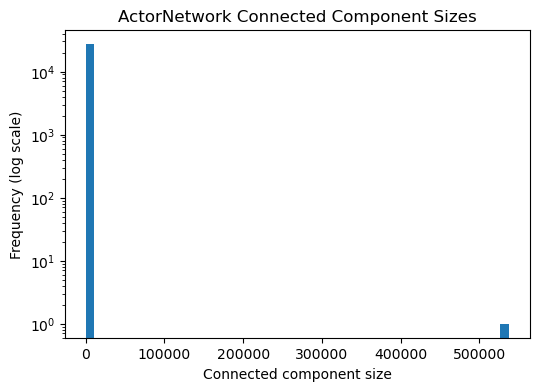

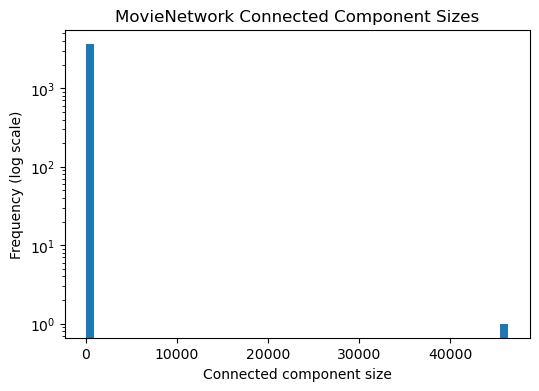

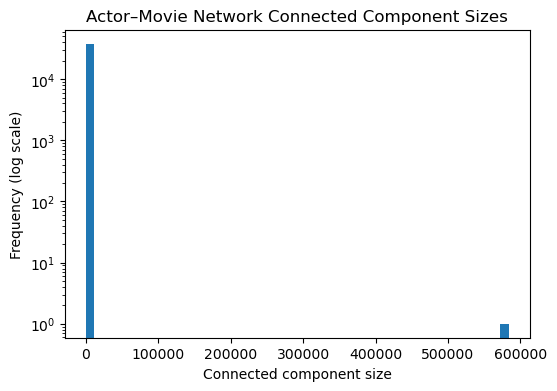

In [19]:
from MovieNetwork import MovieNetwork

#an=ActorNetwork()
#mn=MovieNetwork()
#amn=ActorMovieNetwork()
plot_component_histogram(
    an.getConnectedComponentSizes(),
    "ActorNetwork Connected Component Sizes"
)

plot_component_histogram(
    mn.getConnectedComponentSizes(),
    "MovieNetwork Connected Component Sizes"
)

plot_component_histogram(
    amn.getConnectedComponentSizes(),
    "Actor–Movie Network Connected Component Sizes"
)
